In [2]:
import galaxywrap as gw
from pathlib import Path
from astropy.io import fits
import warnings
import matplotlib.pyplot as plt

exampledirectory = Path(gw.__path__[0]) / '../scripts/EXAMPLE'

You must have a galfit variable defined that containes the path to the galfit executable and is accessible by os.environ.
If it is not found the package will raise a warning and you can set it manually by typing

gw.core.galfitcmd = "/my/path/to/galfit"

We will now load the image that will be fitted. The wcs in the example image is not FITS standard and we want to ignore the this concerning warning that is raised by astropy.

In [3]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', fits.verify.VerifyWarning)
    image = gw.image.read(exampledirectory/'gal.fits')

/Users/peterlustig/Documents/galaxywrap/galaxywrap/utils.py:65: UserWarning: Could not find magnitude zeropoint, must be set manually
  warnings.warn('Could not find magnitude zeropoint, '


Important header information is tried to be read and a warning for each information that is not found is raised. In this case the header does not provide the magnitude zeropoint for the image and we will set it manually. We will also modify the platescale that is automatically read from the wcs but FOR SOME REASON?? does not agree with the platescale used in the galfit demo fitfile. If you have a mask or a sigmaimage fit can also be read or set up manually by

image.mask = mymask
and
image.uncertainty = myuncertainty

First we will plot the image and then take a look at its properties.

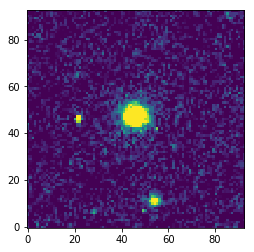

magzpt: None
exptime: 1040.0
platescale: [0.04999672 0.05000166]
gain: 1
ncombine: 1
unit: ELECTRONS


In [4]:
fig, ax = plt.subplots(1, 1)
ax.imshow(image, origin='lower', vmin=0, vmax=75)
plt.show()

print(image.properties)

We will now add the magnitude zeropoint and correct the platescale value. To do the latter we can either give the platescale in both directions or just input a scalar that is assumed to be the value for both directions.

In [5]:
image.properties.magzpt = 26.563
image.properties.platescale = 0.038

print(image.properties)

magzpt: 26.563
exptime: 1040.0
platescale: [0.038, 0.038]
gain: 1
ncombine: 1
unit: ELECTRONS


Now we want to load and set up the psf.

In [6]:
psf = gw.psf(fits.getdata(exampledirectory/'psf.fits'), convolutionbox=100)

A finesampling factor of 1 is assumed by default but can be changed in the initialization or afterwarts.

now, with all data loaded, we will set up our model. The component module provides the available galfit components that can be added to a model object and then be fitted to the data to remember, the galfit example fitfile is the following:

Object number: 1  
0) sersic                 #  object type  
 1) 48.5180  51.2800  1 1  #  position x, y  
 3) 20.0890     1          #  Integrated magnitude  
 4) 5.1160      1          #  R_e (half-light radius)   [pix]  
 5) 4.2490      1          #  Sersic index n (de Vaucouleurs n=4)  
 6) 0.0000      0          #     -----  
 7) 0.0000      0          #     -----  
 8) 0.0000      0          #     -----  
 9) 0.7570      1          #  axis ratio (b/a)  
10) -60.3690    1          #  position angle (PA) [deg: Up=0, Left=90]  
 Z) 0                      #  output option (0 = resid., 1 = Don't subtract)

Object number: 2  
 0) sky                    #  object type  
 1) 1.3920      1          #  sky background at center of fitting region [ADUs]  
 2) 0.0000      0          #  dsky/dx (sky gradient in x)  
 3) 0.0000      0          #  dsky/dy (sky gradient in y)  
 Z) 0                      #  output option (0 = resid., 1 = Don't subtract)

we will  first setup the sersic:

In [7]:
sersic = gw.components.sersic(47.5180, 50.2800, 20.089, 5.116,
                              4.2490, 0.7570, -60.3690)

The initial value for x and y differs from the exmple file by 1 pixel because indexing starts with 0.  
Now the sky:

In [8]:
sky = gw.components.sky(1.392, 0, 0, fixed={'dbkg_dx': True, 'dbkg_dy': True})

Constraints concerning only one component (range of parameter value or range of parameter value relativ to initial guess value) can also be defined in the initialization

In [9]:
model = gw.model([sersic, sky])
components, stats, image, model, residual = model.fit(image, psf)

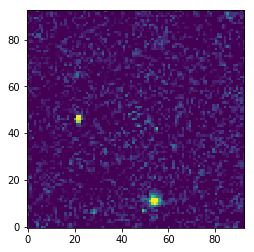

 comp     x    x_unc  x_flag    y    ... dsdx_flag dsdy dsdy_unc dsdy_flag
------ ------- ------ ------ ------- ... --------- ---- -------- ---------
sersic 46.5231 0.0142        48.2538 ...        --   --       --        --
   sky    47.0   -1.0  fixed    47.0 ...     fixed  0.0       -1     fixed


In [12]:
fig, ax = plt.subplots(1, 1)
ax.imshow(residual, origin='lower', vmin=0, vmax=75)
plt.show()

print(components)